# Libraries Import

In [ ]:
import spacy
from textblob import TextBlob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from video.show_video import show_video
from video.video_maker import VideoMaker
from load_bar import LoadBarWithAutoIncrement, LoadBarReset
from object.object_cache import saveObject

import kagglehub

import os

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
nlp = spacy.load('en_core_web_sm')
LoadBarReset()

# Dataset Import

In [ ]:
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\yosef\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


In [ ]:
files = os.listdir(path)
files

['twitter_training.csv', 'twitter_validation.csv']

In [ ]:
df = pd.concat(
    [
        pd.read_csv(os.path.join(path, files[0]), header=None),
        pd.read_csv(os.path.join(path, files[1]), header=None),
    ]
)

# Dataset Exploration

In [ ]:
len(df)

75682

In [ ]:
df.columns

Index([0, 1, 2, 3], dtype='int64')

In [ ]:
df.describe(include='all')

,0,1,2,3
count,75682.000000,75682,75682,74996
unique,NaN,32,4,69974
top,NaN,TomClancysRainbowSix,Negative,
freq,NaN,2435,22808,172
mean,6432.579583,NaN,NaN,NaN
std,3740.243463,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3196.000000,NaN,NaN,NaN
50%,6423.000000,NaN,NaN,NaN
75%,9602.000000,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       75682 non-null  int64 
 1   1       75682 non-null  object
 2   2       75682 non-null  object
 3   3       74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [ ]:
pd.concat([df.head(), df.tail()])

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.
999,6960,johnson&johnson,Neutral,Johnson & Johnson to stop selling talc baby po...


# Dataset Preprocessing

In [ ]:
df = df.iloc[:,[2,3]]

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.columns = ['target', 'sentence']

In [ ]:
df

,target,sentence
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
75677,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,Positive,Today sucked so it’s time to drink wine n play...
75680,Positive,Bought a fraction of Microsoft today. Small wins.


Null Values

In [ ]:
100 * df.isna().sum() / len(df)

target      0.000000
sentence    0.906424
dtype: float64

In [ ]:
df.dropna(inplace=True)

In [ ]:
100 * df.isna().sum() / len(df)

target      0.0
sentence    0.0
dtype: float64

# Dataset cleaning

Casefolding and remove now characters

In [ ]:
def cleanSentence(msg):
    LoadBarWithAutoIncrement('cleanSentence', len(df))

    pat_non_char = r'[^A-Za-z]'

    msg = re.sub(pat_non_char, ' ', msg)    
    msg = msg.lower() #Casefolding

    return msg

Remove repeated spaces

In [ ]:
def cleanSpaces(msg):
    LoadBarWithAutoIncrement('cleanSpaces', len(df))

    pat_repeated_space = re.compile(r'\s+')

    msg = re.sub(pat_repeated_space, ' ', msg)
    msg = msg.strip()
    
    return msg

Stemming

In [ ]:
def normalizeSentence(msg):
    LoadBarWithAutoIncrement('normalize', len(df))

    msg = nlp(msg)
    # tokens = [token for token in msg]
    lemma = [token.lemma_ for token in msg]
    return ' '.join(lemma)

Stop Words

In [ ]:
def removeStopWord(msg):
    LoadBarWithAutoIncrement('stopword', len(df))

    msg = nlp(msg)
    msg = [token.text for token in msg if token.is_stop == False]
    return ' '.join(msg)

Remove single character

In [ ]:
def removeSingleChar(msg):
    LoadBarWithAutoIncrement('singleChar', len(df))

    pattern = re.compile(r'\b\w\b')
    pat_repeated_space = re.compile('r\s+')

    msg = re.sub(pattern, ' ', msg)   
    msg = re.sub(pat_repeated_space, ' ', msg)
    msg = msg.strip()

    return msg

Spell Correction

In [ ]:
def spellCorrect(msg):
    LoadBarWithAutoIncrement('spell', len(df))

    msg = nlp(msg)

    msg = [str(TextBlob(token.text).correct()) for token in msg]

    return ' '.join(msg)

In [ ]:
df['sentence'] = df['sentence'].apply(cleanSentence)

Loading: 100.000%, Wait: 000:00:00

In [ ]:
df['sentence'] = df['sentence'].apply(cleanSpaces)

Loading: 100.000%, Wait: 000:00:00

In [ ]:
df['sentence'] = df['sentence'].apply(normalizeSentence)

Loading: 100.000%, Wait: 000:00:00

In [ ]:
df['sentence'] = df['sentence'].apply(removeStopWord)

Loading: 100.000%, Wait: 000:00:00

In [ ]:
df['sentence'] = df['sentence'].apply(removeSingleChar)

Loading: 100.000%, Wait: 000:00:00

In [ ]:
# df['sentence'] = df['sentence'].apply(spellCorrect)

Remove duplicates & Empty Strings & Extra Spaces

In [ ]:
df.drop_duplicates()
df = df[df['sentence']!='']
df['sentence'] = df['sentence'].apply(cleanSpaces)

Loading: 100.000%, Wait: 000:00:00

C:\Users\yosef\AppData\Local\Temp\ipykernel_10068\1847873812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentence'] = df['sentence'].apply(cleanSpaces)


In [ ]:
df

,target,sentence
0,Positive,borderland murder
1,Positive,come borde kill
2,Positive,borderland kill
3,Positive,come borderland murder
4,Positive,borderland murder
...,...,...
75677,Irrelevant,toronto art culture capital canada wonde want ...
75678,Irrelevant,actually good tot bring viewe people hook csgo...
75679,Positive,today suck time drink wine play borderland sun...
75680,Positive,buy fraction microsoft today small win


# Dataset Visualization

Length of each Sentence

In [ ]:
df['length'] = df['sentence'].apply(lambda x: len(x))

C:\Users\yosef\AppData\Local\Temp\ipykernel_10068\3026411251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df['sentence'].apply(lambda x: len(x))


No of unique words

In [ ]:
unique_words = set()

for word in df['sentence']:
    unique_words.update(word.split())

print('Unique Words:', len(unique_words))

Unique Words: 25537


<Axes: xlabel='target', ylabel='count'>

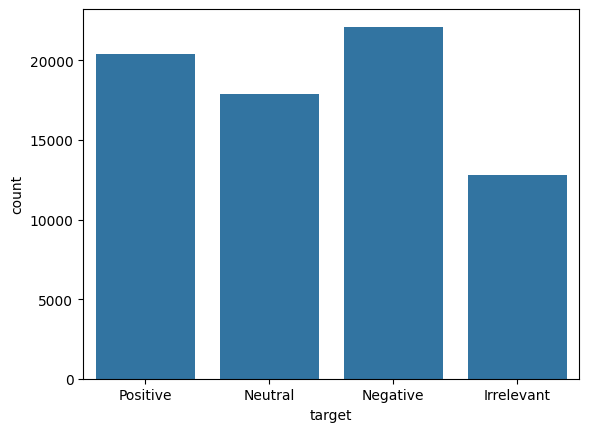

In [ ]:
sns.countplot(data=df, x='target')

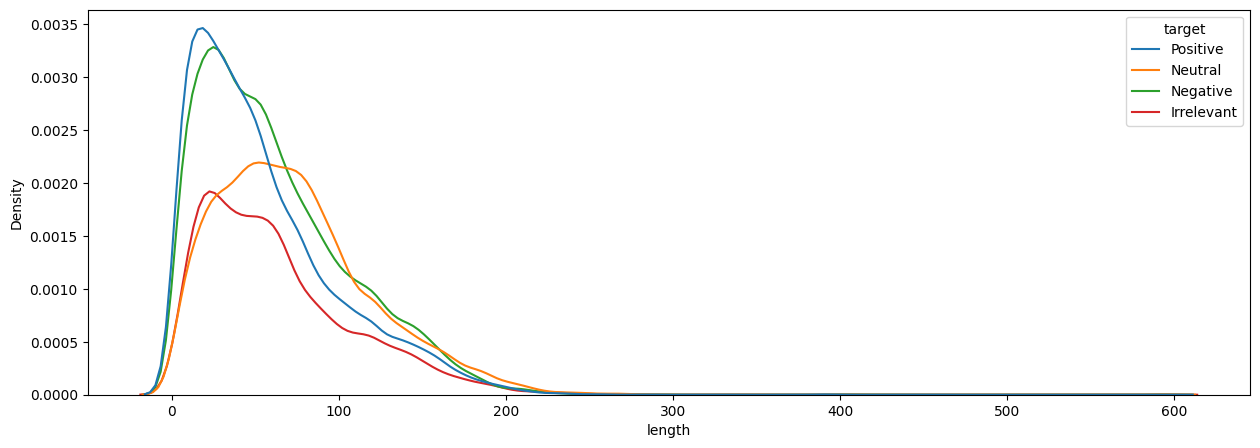

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(df, x='length', hue='target')
plt.show()

#  Text Representation

TF-IDF

In [ ]:
corpus = df['sentence'].values
target = df['target'].values

In [ ]:
max_features = int(len(unique_words) * 0.10) #ngram= 1, 2, 3
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features = max_features)
tfidf.fit(corpus)

TfidfVectorizer(max_features=2553, ngram_range=(1, 3))

In [ ]:
corpus_vect =  tfidf.transform(corpus).toarray()

In [ ]:
print("Print some vectors randomly\n")
for i in np.random.randint(corpus_vect.shape[0], size=10) :
    print(f'Sentence {i:7d}:', list(map(lambda x:float(x),filter( lambda v: v!=0 ,corpus_vect[i] ))))   

Print some vectors randomly

Sentence   72059: [0.15939090461875707, 0.2924004991850491, 0.38434265107348137, 0.1600442742397621, 0.40420587827304, 0.2759661800807821, 0.2593874956570516, 0.20332070575504185, 0.21321722909654034, 0.21321722909654034, 0.27031561687865485, 0.20458441041313355, 0.21034749122313534, 0.240709652839654, 0.24406238191363427]
Sentence   31749: [0.2579013923864772, 0.4003040241352164, 0.21862997766859002, 0.30377427084190817, 0.38160944900488875, 0.409164698674167, 0.21379519946656053, 0.3743796699974473, 0.3664091135221488]
Sentence   12100: [0.6649364849315671, 0.5467289969202375, 0.5088682294400415]
Sentence   31129: [0.4162837959349349, 0.7862982892243396, 0.4565553653226279]
Sentence   43390: [0.36873315777054777, 0.295230296394748, 0.35734963101467615, 0.28734450428536407, 0.22960249290223497, 0.34890367025335073, 0.2607002941430383, 0.20446583113567188, 0.2378574756709944, 0.28023380593736846, 0.25515920546367066, 0.18224380452761885, 0.22127160469925258

# Dataset Exportation

In [ ]:
df_clean = pd.DataFrame(
            corpus_vect,
            columns=tfidf.get_feature_names_out()
        )
  
df_clean['target'] = pd.Series(target)

In [ ]:
df_clean

,aa,aa aa,aa aa aa,ab,abandon,ability,able,able play,absolute,absolutely,...,youtu,youtube,youtube com,youtube com watch,yu,yu yu,zero,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
saveObject(tfidf, 'TfidfVectorizer')

Object successfully saved to cache\TfidfVectorizer.pickle


In [ ]:
df_clean.to_csv('clean_dataset.csv', index=False)